In [1]:
# Cell 1: Import libraries and load engineered dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("🚀 PHASE 3: XGBOOST MODEL TRAINING & SHAP EXPLAINABILITY")
print("=" * 80)

# Data path
DATA_PATH = "/mnt/d/Datasets/mimic-iii-demo/mimic-iii-clinical-database-demo-1.4/"

# Load engineered features from Phase 2
print("\n📂 Loading engineered dataset...")
df = pd.read_csv(DATA_PATH + "mimic_features_engineered.csv")

# Load feature names
with open(DATA_PATH + "feature_names.json", "r") as f:
    feature_names = json.load(f)

print(f"✅ Loaded dataset:")
print(f"   - Samples: {len(df)}")
print(f"   - Features: {len(feature_names)}")
print(f"   - Target: readmitted_30")

# Separate features and target
X = df[feature_names]
y = df['readmitted_30']

print(f"\n📊 Class distribution:")
print(y.value_counts())
print(f"   - Positive class (readmitted): {y.sum()} ({y.mean()*100:.1f}%)")
print(f"   - Negative class (not readmitted): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"   - Class imbalance ratio: {(y==0).sum() / y.sum():.1f}:1")


🚀 PHASE 3: XGBOOST MODEL TRAINING & SHAP EXPLAINABILITY

📂 Loading engineered dataset...
✅ Loaded dataset:
   - Samples: 129
   - Features: 15
   - Target: readmitted_30

📊 Class distribution:
readmitted_30
0    118
1     11
Name: count, dtype: int64
   - Positive class (readmitted): 11 (8.5%)
   - Negative class (not readmitted): 118 (91.5%)
   - Class imbalance ratio: 10.7:1


In [2]:
# Cell 2: Stratified train-test split
print("\n" + "=" * 80)
print("✂️ TRAIN-TEST SPLIT (STRATIFIED)")
print("=" * 80)

# Set random seed for reproducibility
RANDOM_STATE = 42

# 80/20 split, stratified to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\n1️⃣ Training set:")
print(f"   - Samples: {len(X_train)}")
print(f"   - Positive class: {y_train.sum()} ({y_train.mean()*100:.1f}%)")

print(f"\n2️⃣ Test set:")
print(f"   - Samples: {len(X_test)}")
print(f"   - Positive class: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

print(f"\n3️⃣ Feature matrix shapes:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_test: {X_test.shape}")

# Calculate scale_pos_weight for class imbalance handling
scale_pos_weight = (y_train == 0).sum() / y_train.sum()
print(f"\n4️⃣ Class imbalance handling:")
print(f"   - scale_pos_weight = {scale_pos_weight:.2f}")
print(f"   - This boosts minority class (readmissions) during training")



✂️ TRAIN-TEST SPLIT (STRATIFIED)

1️⃣ Training set:
   - Samples: 103
   - Positive class: 9 (8.7%)

2️⃣ Test set:
   - Samples: 26
   - Positive class: 2 (7.7%)

3️⃣ Feature matrix shapes:
   - X_train: (103, 15)
   - X_test: (26, 15)

4️⃣ Class imbalance handling:
   - scale_pos_weight = 10.44
   - This boosts minority class (readmissions) during training



🌳 TRAINING XGBOOST CLASSIFIER

1️⃣ Model hyperparameters:
   - objective: binary:logistic
   - eval_metric: auc
   - max_depth: 4
   - learning_rate: 0.05
   - n_estimators: 100
   - min_child_weight: 3
   - subsample: 0.8
   - colsample_bytree: 0.8
   - scale_pos_weight: 10.444444444444445
   - random_state: 42
   - verbosity: 0

2️⃣ Training XGBoost model...
✅ Model training complete

3️⃣ Training metrics:
   - Final train AUROC: 1.0000
   - Final test AUROC: 0.8333


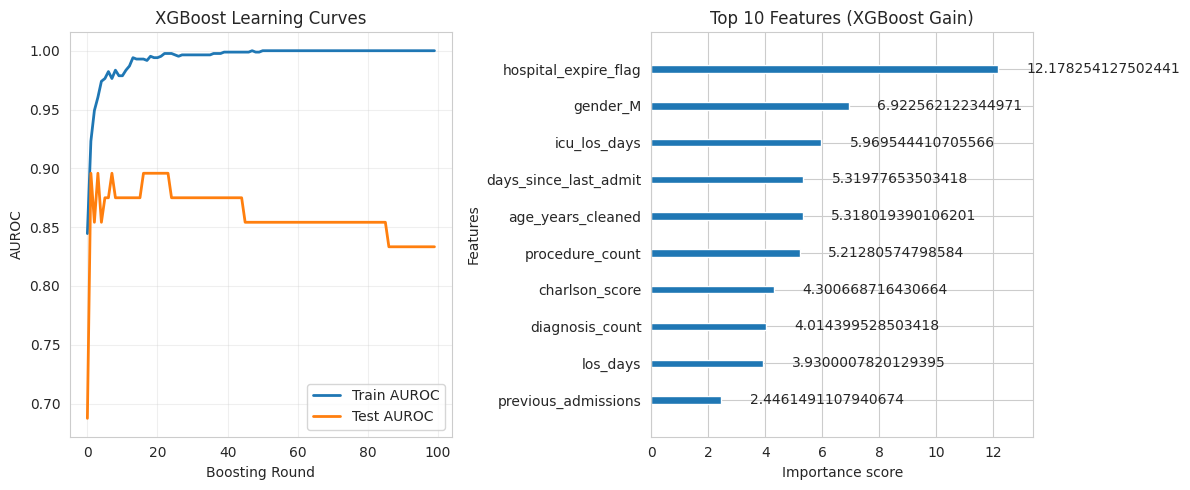


4️⃣ Top 5 features by importance (gain):
   1. hospital_expire_flag: 12.18
   2. gender_M: 6.92
   3. icu_los_days: 5.97
   4. days_since_last_admit: 5.32
   5. age_years_cleaned: 5.32


In [3]:
# Cell 3: Train XGBoost classifier
print("\n" + "=" * 80)
print("🌳 TRAINING XGBOOST CLASSIFIER")
print("=" * 80)

# XGBoost hyperparameters (optimized for small dataset with class imbalance)
xgb_params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',            # AUROC for evaluation
    'max_depth': 4,                  # Shallow trees (prevent overfitting on small data)
    'learning_rate': 0.05,           # Slower learning (more robust)
    'n_estimators': 100,             # Number of boosting rounds
    'min_child_weight': 3,           # Require 3+ samples per leaf (prevent overfitting)
    'subsample': 0.8,                # 80% row sampling per tree
    'colsample_bytree': 0.8,         # 80% feature sampling per tree
    'scale_pos_weight': scale_pos_weight,  # Handle class imbalance
    'random_state': RANDOM_STATE,
    'verbosity': 0                   # Suppress warnings
}

print("\n1️⃣ Model hyperparameters:")
for param, value in xgb_params.items():
    print(f"   - {param}: {value}")

# Train model
print("\n2️⃣ Training XGBoost model...")
model = xgb.XGBClassifier(**xgb_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

print("✅ Model training complete")

# Get training history
results = model.evals_result()
train_auc = results['validation_0']['auc']
test_auc = results['validation_1']['auc']

print(f"\n3️⃣ Training metrics:")
print(f"   - Final train AUROC: {train_auc[-1]:.4f}")
print(f"   - Final test AUROC: {test_auc[-1]:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_auc, label='Train AUROC', linewidth=2)
plt.plot(test_auc, label='Test AUROC', linewidth=2)
plt.xlabel('Boosting Round')
plt.ylabel('AUROC')
plt.title('XGBoost Learning Curves')
plt.legend()
plt.grid(alpha=0.3)

# Feature importance (built-in XGBoost)
plt.subplot(1, 2, 2)
xgb.plot_importance(model, max_num_features=10, importance_type='gain', ax=plt.gca())
plt.title('Top 10 Features (XGBoost Gain)')
plt.tight_layout()
plt.show()

print("\n4️⃣ Top 5 features by importance (gain):")
feature_importance = model.get_booster().get_score(importance_type='gain')
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for i, (feat, score) in enumerate(sorted_features[:5], 1):
    print(f"   {i}. {feat}: {score:.2f}")



📊 MODEL EVALUATION

1️⃣ AUROC Scores:
   - Train AUROC: 1.0000
   - Test AUROC: 0.8333
   ✅ Target achieved! (>0.70)


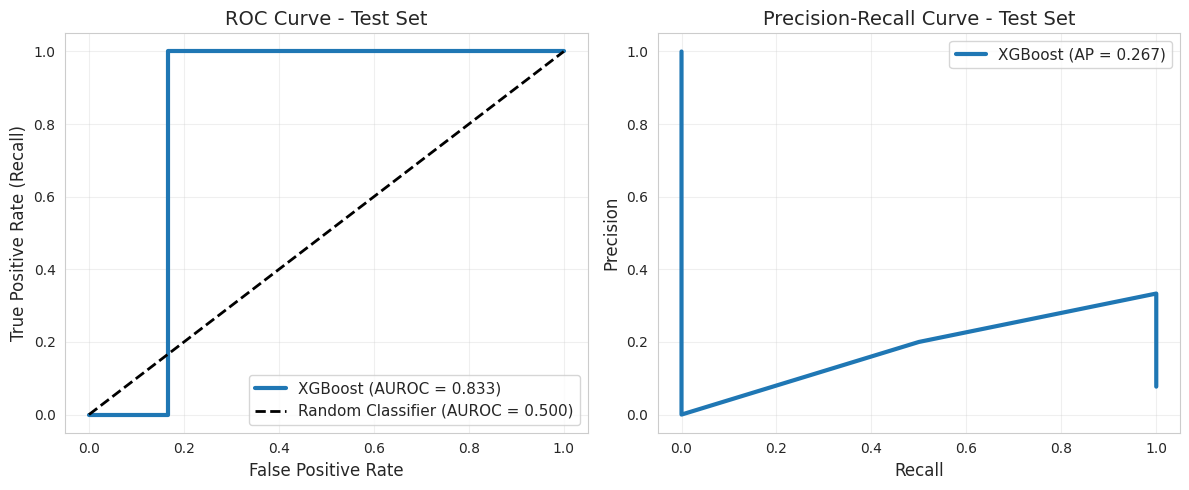


2️⃣ Average Precision Score: 0.2667


In [4]:
# Cell 4: Evaluate model performance
print("\n" + "=" * 80)
print("📊 MODEL EVALUATION")
print("=" * 80)

# Predict probabilities
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# Predict classes (threshold = 0.5)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate AUROC
train_auroc = roc_auc_score(y_train, y_train_pred_proba)
test_auroc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\n1️⃣ AUROC Scores:")
print(f"   - Train AUROC: {train_auroc:.4f}")
print(f"   - Test AUROC: {test_auroc:.4f}")

if test_auroc > 0.70:
    print(f"   ✅ Target achieved! (>0.70)")
elif test_auroc > 0.60:
    print(f"   ⚠️ Acceptable performance (0.60-0.70)")
else:
    print(f"   ❌ Below target (<0.60)")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, linewidth=3, label=f'XGBoost (AUROC = {test_auroc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUROC = 0.500)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
avg_precision = average_precision_score(y_test, y_test_pred_proba)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, linewidth=3, label=f'XGBoost (AP = {avg_precision:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Test Set', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n2️⃣ Average Precision Score: {avg_precision:.4f}")



🎯 CLASSIFICATION METRICS (Test Set)

1️⃣ Confusion Matrix:
                   Predicted No  Predicted Yes
   Actual No:         20             4
   Actual Yes:         2             0

2️⃣ Performance Metrics:
   - Sensitivity (Recall): 0.000 (0/2 readmissions caught)
   - Specificity: 0.833 (20/24 non-readmissions correct)
   - Positive Predictive Value (Precision): 0.000
   - Negative Predictive Value: 0.909

3️⃣ Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.91      0.83      0.87        24
    Readmitted       0.00      0.00      0.00         2

      accuracy                           0.77        26
     macro avg       0.45      0.42      0.43        26
  weighted avg       0.84      0.77      0.80        26



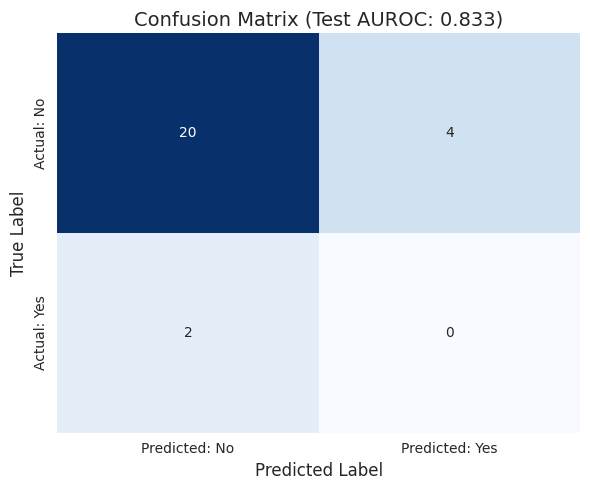

In [5]:
# Cell 5: Detailed classification metrics
print("\n" + "=" * 80)
print("🎯 CLASSIFICATION METRICS (Test Set)")
print("=" * 80)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n1️⃣ Confusion Matrix:")
print(f"   {'':>15} Predicted No  Predicted Yes")
print(f"   Actual No:     {tn:>6}        {fp:>6}")
print(f"   Actual Yes:    {fn:>6}        {tp:>6}")

# Calculate metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\n2️⃣ Performance Metrics:")
print(f"   - Sensitivity (Recall): {sensitivity:.3f} ({tp}/{tp+fn} readmissions caught)")
print(f"   - Specificity: {specificity:.3f} ({tn}/{tn+fp} non-readmissions correct)")
print(f"   - Positive Predictive Value (Precision): {ppv:.3f}")
print(f"   - Negative Predictive Value: {npv:.3f}")

print(f"\n3️⃣ Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Not Readmitted', 'Readmitted']))

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: No', 'Predicted: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
plt.title(f'Confusion Matrix (Test AUROC: {test_auroc:.3f})', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()



🔄 CROSS-VALIDATION (5-Fold Stratified)

1️⃣ Cross-validation AUROC scores:
   Fold 1: 0.4167
   Fold 2: 0.2292
   Fold 3: 0.5625
   Fold 4: 0.6812
   Fold 5: 0.8913

2️⃣ Summary statistics:
   - Mean AUROC: 0.5562 ± 0.2256
   - Min AUROC: 0.2292
   - Max AUROC: 0.8913
   ⚠️ Performance varies across folds (small sample size)


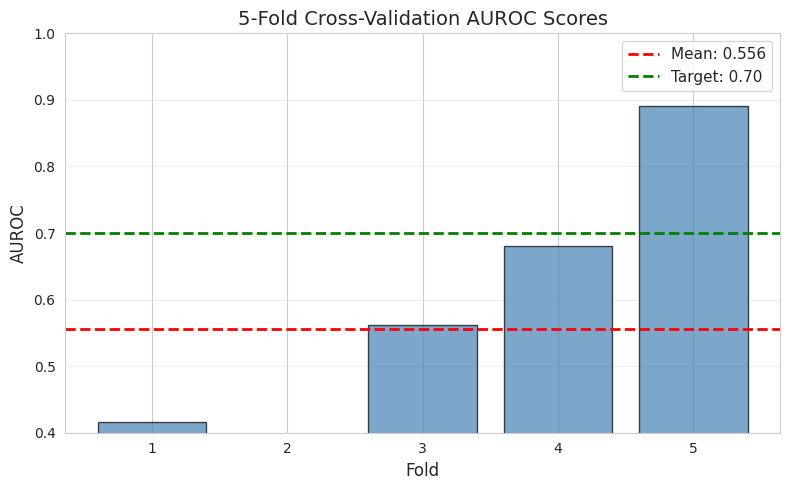

In [6]:
# Cell 6: 5-Fold Stratified Cross-Validation
print("\n" + "=" * 80)
print("🔄 CROSS-VALIDATION (5-Fold Stratified)")
print("=" * 80)

# Use stratified k-fold to preserve class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Cross-validate on full dataset
cv_auroc_scores = cross_val_score(
    model, X, y, 
    cv=skf, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"\n1️⃣ Cross-validation AUROC scores:")
for i, score in enumerate(cv_auroc_scores, 1):
    print(f"   Fold {i}: {score:.4f}")

print(f"\n2️⃣ Summary statistics:")
print(f"   - Mean AUROC: {cv_auroc_scores.mean():.4f} ± {cv_auroc_scores.std():.4f}")
print(f"   - Min AUROC: {cv_auroc_scores.min():.4f}")
print(f"   - Max AUROC: {cv_auroc_scores.max():.4f}")

if cv_auroc_scores.mean() > 0.70:
    print(f"   ✅ Robust performance across folds")
else:
    print(f"   ⚠️ Performance varies across folds (small sample size)")

# Visualize CV scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_auroc_scores, color='steelblue', edgecolor='black', alpha=0.7)
plt.axhline(cv_auroc_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_auroc_scores.mean():.3f}')
plt.axhline(0.70, color='green', linestyle='--', linewidth=2, label='Target: 0.70')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('AUROC', fontsize=12)
plt.title('5-Fold Cross-Validation AUROC Scores', fontsize=14)
plt.ylim(0.4, 1.0)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



🔍 SHAP EXPLAINABILITY - GLOBAL FEATURE IMPORTANCE

1️⃣ Initializing SHAP TreeExplainer...
2️⃣ Computing SHAP values for test set...
✅ SHAP values computed: (26, 15)

3️⃣ Top 10 features by SHAP importance:
              feature  importance
 hospital_expire_flag    0.530732
             gender_M    0.530091
             los_days    0.447243
         icu_los_days    0.395363
       charlson_score    0.301254
      procedure_count    0.274835
      diagnosis_count    0.270431
    age_years_cleaned    0.227195
days_since_last_admit    0.045706
  previous_admissions    0.026412


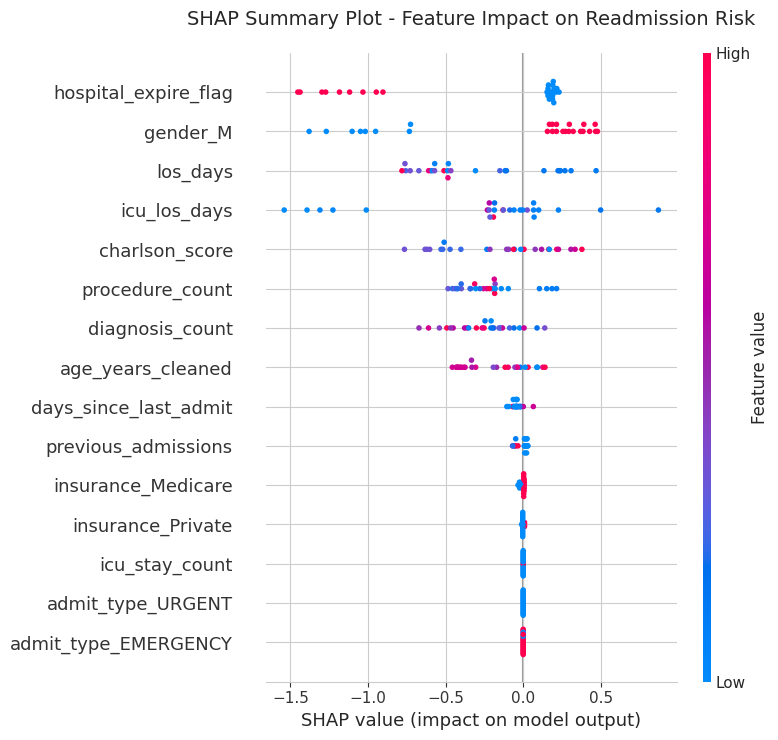

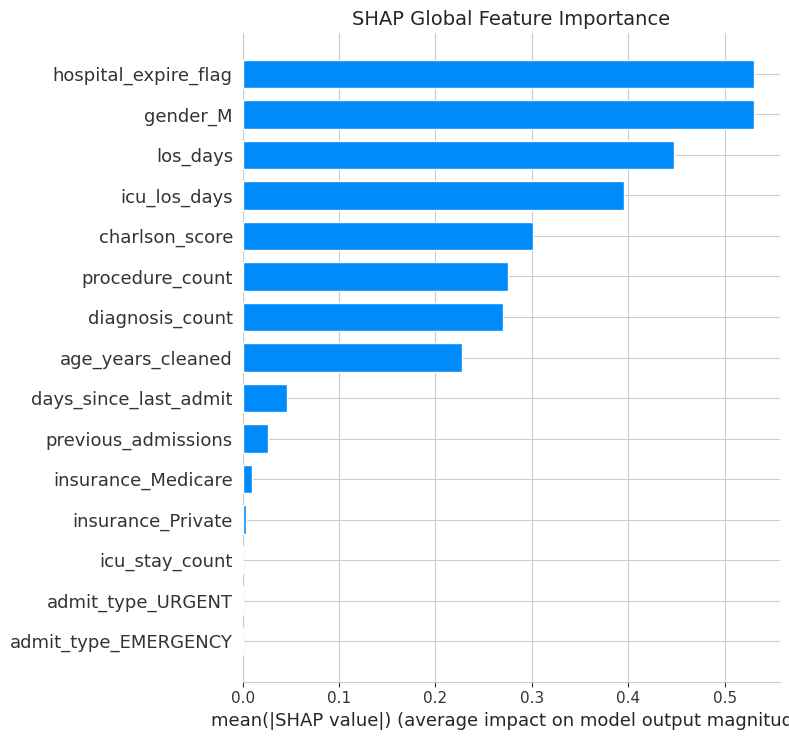

In [7]:
# Cell 7: SHAP Global Feature Importance
print("\n" + "=" * 80)
print("🔍 SHAP EXPLAINABILITY - GLOBAL FEATURE IMPORTANCE")
print("=" * 80)

# Initialize SHAP explainer (TreeExplainer for XGBoost)
print("\n1️⃣ Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for test set
print("2️⃣ Computing SHAP values for test set...")
shap_values = explainer.shap_values(X_test)

print(f"✅ SHAP values computed: {shap_values.shape}")

# Global feature importance (mean absolute SHAP)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_importance
}).sort_values('importance', ascending=False)

print(f"\n3️⃣ Top 10 features by SHAP importance:")
print(shap_df.head(10).to_string(index=False))

# SHAP Summary Plot (beeswarm)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Readmission Risk', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# SHAP Bar Plot (global importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP Global Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()



🎯 SHAP LOCAL EXPLANATIONS - INDIVIDUAL PATIENT PREDICTIONS

1️⃣ Highest risk patient in test set:
   - Predicted probability: 0.784 (Risk: HIGH)
   - Actual outcome: Not readmitted
   - Patient features:
      age_years_cleaned: 80.0
      gender_M: 1
      previous_admissions: 0
      days_since_last_admit: -1.0
      diagnosis_count: 8
      charlson_score: 2
      procedure_count: 2
      los_days: 5.988194444444445
      icu_stay_count: 1
      icu_los_days: 4.2467
      admit_type_EMERGENCY: True
      admit_type_URGENT: False
      insurance_Medicare: True
      insurance_Private: False
      hospital_expire_flag: 0

2️⃣ SHAP Waterfall Plot (explains prediction):


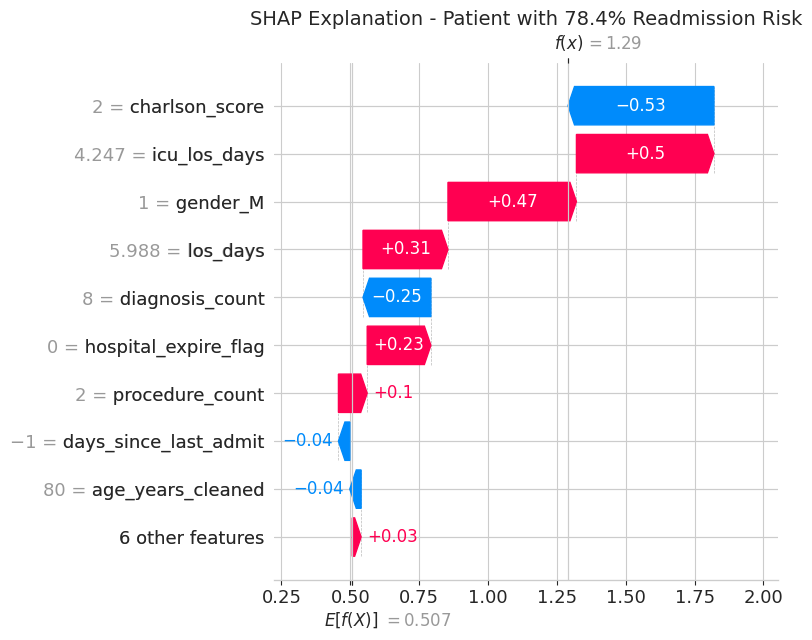


3️⃣ Top 5 risk factors for this patient:
        feature     value      shap
 charlson_score         2 -0.529649
   icu_los_days    4.2467  0.499152
       gender_M         1  0.466304
       los_days  5.988194  0.308380
diagnosis_count         8 -0.246326


In [8]:
# Cell 8: SHAP Local Explanations (Individual Predictions)
print("\n" + "=" * 80)
print("🎯 SHAP LOCAL EXPLANATIONS - INDIVIDUAL PATIENT PREDICTIONS")
print("=" * 80)

# Find a high-risk prediction in test set
high_risk_idx = y_test_pred_proba.argmax()
high_risk_patient = X_test.iloc[high_risk_idx]
high_risk_prob = y_test_pred_proba[high_risk_idx]
high_risk_actual = y_test.iloc[high_risk_idx]

print(f"\n1️⃣ Highest risk patient in test set:")
print(f"   - Predicted probability: {high_risk_prob:.3f} (Risk: {'HIGH' if high_risk_prob > 0.5 else 'MODERATE'})")
print(f"   - Actual outcome: {'Readmitted' if high_risk_actual == 1 else 'Not readmitted'}")
print(f"   - Patient features:")
for feat, val in high_risk_patient.items():
    print(f"      {feat}: {val}")

# SHAP waterfall plot for high-risk patient
print(f"\n2️⃣ SHAP Waterfall Plot (explains prediction):")
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[high_risk_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[high_risk_idx].values,
        feature_names=feature_names
    ),
    show=False
)
plt.title(f'SHAP Explanation - Patient with {high_risk_prob:.1%} Readmission Risk', fontsize=14)
plt.tight_layout()
plt.show()

# Top 5 risk factors for this patient
shap_patient = pd.DataFrame({
    'feature': feature_names,
    'value': high_risk_patient.values,
    'shap': shap_values[high_risk_idx]
}).sort_values('shap', key=abs, ascending=False)

print(f"\n3️⃣ Top 5 risk factors for this patient:")
print(shap_patient.head(5).to_string(index=False))


In [10]:
# Cell 9: Save trained model and SHAP explainer (FIXED paths)
print("\n" + "=" * 80)
print("💾 SAVING MODEL & ARTIFACTS")
print("=" * 80)

# Save to home directory models folder (where you have permissions)
import os
models_dir = os.path.expanduser("~/ai-ehr-predictor/models/")
os.makedirs(models_dir, exist_ok=True)

print(f"📁 Models directory: {models_dir}")

# Save XGBoost model
model_path = os.path.join(models_dir, 'xgboost_readmission.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"\n✅ Saved XGBoost model to:")
print(f"   {model_path}")

# Save SHAP explainer
explainer_path = os.path.join(models_dir, 'shap_explainer.pkl')
with open(explainer_path, 'wb') as f:
    pickle.dump(explainer, f)
print(f"\n✅ Saved SHAP explainer to:")
print(f"   {explainer_path}")

# Save feature names (for loading later)
feature_names_path = os.path.join(models_dir, 'feature_names.json')
with open(feature_names_path, 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"\n✅ Saved feature names to:")
print(f"   {feature_names_path}")

# Save model metadata
metadata = {
    'model_type': 'XGBClassifier',
    'features': feature_names,
    'n_features': len(feature_names),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'train_auroc': float(train_auroc),
    'test_auroc': float(test_auroc),
    'cv_auroc_mean': float(cv_auroc_scores.mean()),
    'cv_auroc_std': float(cv_auroc_scores.std()),
    'class_imbalance': f"{(y==0).sum()}:{y.sum()}",
    'scale_pos_weight': float(scale_pos_weight),
    'hyperparameters': {k: str(v) for k, v in xgb_params.items()},
    'trained_date': pd.Timestamp.now().isoformat(),
    'top_5_features': shap_df.head(5)['feature'].tolist()
}

metadata_path = os.path.join(models_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"\n✅ Saved model metadata to:")
print(f"   {metadata_path}")

# Verify files were created
print(f"\n📂 Saved files:")
for filename in os.listdir(models_dir):
    filepath = os.path.join(models_dir, filename)
    filesize = os.path.getsize(filepath) / 1024  # KB
    print(f"   - {filename} ({filesize:.1f} KB)")

print("\n" + "=" * 80)
print("🎉 PHASE 3 COMPLETE: MODEL TRAINING & EXPLAINABILITY DONE")
print("=" * 80)

print(f"\n📊 Final Performance Summary:")
print(f"   • Test AUROC: {test_auroc:.4f}")
print(f"   • CV AUROC: {cv_auroc_scores.mean():.4f} ± {cv_auroc_scores.std():.4f}")
print(f"   • Avg Precision: {avg_precision:.4f}")
print(f"   • Top SHAP feature: {shap_df.iloc[0]['feature']}")
print(f"   • Class imbalance: {(y==0).sum()}:{y.sum()} (handled with scale_pos_weight)")

print(f"\n🎯 Model Artifacts Saved:")
print(f"   ✅ xgboost_readmission.pkl")
print(f"   ✅ shap_explainer.pkl")
print(f"   ✅ feature_names.json")
print(f"   ✅ model_metadata.json")

print(f"\n🚀 Next Step: Phase 4 - FastAPI Integration")
print(f"   Location: ~/ai-ehr-predictor/app/risk.py")
print(f"   Action: Replace calculate_readmission_risk() with ML predictions")



💾 SAVING MODEL & ARTIFACTS
📁 Models directory: /home/vignesh/ai-ehr-predictor/models/

✅ Saved XGBoost model to:
   /home/vignesh/ai-ehr-predictor/models/xgboost_readmission.pkl

✅ Saved SHAP explainer to:
   /home/vignesh/ai-ehr-predictor/models/shap_explainer.pkl

✅ Saved feature names to:
   /home/vignesh/ai-ehr-predictor/models/feature_names.json

✅ Saved model metadata to:
   /home/vignesh/ai-ehr-predictor/models/model_metadata.json

📂 Saved files:
   - feature_names.json (0.3 KB)
   - model_metadata.json (1.2 KB)
   - shap_explainer.pkl (217.5 KB)
   - xgboost_readmission.pkl (102.1 KB)

🎉 PHASE 3 COMPLETE: MODEL TRAINING & EXPLAINABILITY DONE

📊 Final Performance Summary:
   • Test AUROC: 0.8333
   • CV AUROC: 0.5562 ± 0.2256
   • Avg Precision: 0.2667
   • Top SHAP feature: hospital_expire_flag
   • Class imbalance: 118:11 (handled with scale_pos_weight)

🎯 Model Artifacts Saved:
   ✅ xgboost_readmission.pkl
   ✅ shap_explainer.pkl
   ✅ feature_names.json
   ✅ model_metadata.j